# Check number of waters near Y501 in rest cache

In [1]:
import mdtraj as md
import numpy as np
import pickle
import os
from tqdm import tqdm_notebook
from simtk.openmm import app
from simtk.openmm import unit
import matplotlib.pyplot as plt
from pymbar import timeseries

In [2]:
def new_positions(hybrid_positions):
    n_atoms_new = htf._topology_proposal.n_atoms_new
    hybrid_indices = [htf._new_to_hybrid_map[idx] for idx in range(n_atoms_new)]
    return hybrid_positions[hybrid_indices, :]
    
def old_positions(hybrid_positions):
    n_atoms_old = htf._topology_proposal.n_atoms_old
    hybrid_indices = [htf._old_to_hybrid_map[idx] for idx in range(n_atoms_old)]
    return hybrid_positions[hybrid_indices, :]

def make_traj(outdir, htf, i, phase, name, endstate, is_old=True, keep_solvent=False):
    with open(os.path.join(outdir, f"{i}_{phase}_{name}_1ns_snapshots.npy"), "rb") as f:
        cache = np.load(f)
        
    lengths = np.array([val[i].value_in_unit_system(unit.md_unit_system) for i, val in enumerate(htf.hybrid_system.getDefaultPeriodicBoxVectors())])
    lengths = np.array([lengths], dtype=np.float64)
    lengths = np.repeat(lengths, 100, axis=0)

    angles = np.array([90, 90, 90])
    angles = np.repeat(np.array([angles]), 100, axis=0)
        
    if is_old:
        old_pos = np.zeros(shape=(100, htf._topology_proposal.old_topology.getNumAtoms(), 3))
        for j, pos in tqdm_notebook(enumerate(cache)):
            old_pos[j] = old_positions(unit.Quantity(pos, unit=unit.nanometers)).value_in_unit_system(unit.md_unit_system)
        
        traj = md.Trajectory(old_pos, md.Topology.from_openmm(htf._topology_proposal.old_topology), unitcell_lengths=lengths, unitcell_angles=angles)
    else:
        new_pos = np.zeros(shape=(100, htf._topology_proposal.new_topology.getNumAtoms(), 3))
        for j, pos in tqdm_notebook(enumerate(cache)):
            new_pos[j] = new_positions(unit.Quantity(pos, unit=unit.nanometers)).value_in_unit_system(unit.md_unit_system)
        
        traj = md.Trajectory(new_pos, md.Topology.from_openmm(htf._topology_proposal.new_topology), unitcell_lengths=lengths, unitcell_angles=angles)
      

           
#     # Set unit cell vectors in traj 
#     traj.unitcell_vectors = box_vectors
#     print(type(traj.unitcell_vectors[0]))
    traj.image_molecules(inplace=True)
    
#     if not keep_solvent:
#         traj = traj.remove_solvent(exclude=['Na+', 'Cl-'])
    
    return traj
       

## Y501 complex (15/145)

In [12]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/15/145/"
i = 145
phase = 'complex'
htf = pickle.load(open(os.path.join(outdir, f"{i}_{phase}.pickle"), "rb"))

In [13]:
name = "tyr"
endstate = 1
is_old = False
traj_rest_solvent = make_traj(outdir, htf, i, phase, name, endstate, is_old, keep_solvent=True)

[[13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077 11.0688359 ]
 [13.5565     12.78119077

/scratch/lsftmp/2655116.tmpdir/ipykernel_37402/330331542.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for j, pos in tqdm_notebook(enumerate(cache)):


0it [00:00, ?it/s]

In [14]:
traj_rest_solvent.save(os.path.join(outdir, f"{i}_{phase}_Y501_rest.dcd"))
traj_rest_solvent[0].save(os.path.join(outdir, f"{i}_{phase}_Y501_rest.pdb"))

In [24]:
tyr_atoms = []
for atom in traj_rest_solvent.topology.atoms:
    if atom.residue.resSeq == 501 and atom.residue.name == 'TYR':
        if atom.name == 'OH':
            print(atom, atom.residue.resSeq, atom.index)
            tyr_atoms.append(atom.index)

TYR501-OH 501 2620


In [25]:
water_atoms = traj_rest_solvent.topology.select("water and symbol == 'O'")

In [28]:
neighbors = md.compute_neighbors(traj_rest_solvent, 0.5, tyr_atoms, haystack_indices=water_atoms)

Text(0.5, 1.0, 'Y501 complex')

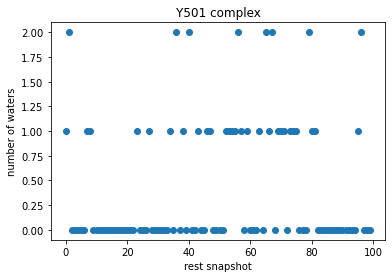

In [29]:
plt.scatter(range(len(neighbors)), [len(frame) for frame in neighbors])
plt.ylabel("number of waters")
plt.xlabel("rest snapshot")
plt.title("Y501 complex")

In [30]:
y501_waters = [len(frame) for frame in neighbors]
timeseries.statisticalInefficiency(y501_waters)


1.8566279930881266

## Y501 complex (15/130)

In [3]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/15/130/"
i = 130
phase = 'complex'
htf = pickle.load(open(os.path.join(outdir, f"{i}_{phase}.pickle"), "rb"))

In [4]:
name = "tyr"
endstate = 1
is_old = False
traj_rest_solvent = make_traj(outdir, htf, i, phase, name, endstate, is_old, keep_solvent=True)

/scratch/lsftmp/2663681.tmpdir/ipykernel_2464/2493333641.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for j, pos in tqdm_notebook(enumerate(cache)):


0it [00:00, ?it/s]

In [5]:
traj_rest_solvent.save(os.path.join(outdir, f"{i}_{phase}_Y501_rest.dcd"))
traj_rest_solvent[0].save(os.path.join(outdir, f"{i}_{phase}_Y501_rest.pdb"))

In [6]:
tyr_atoms = []
for atom in traj_rest_solvent.topology.atoms:
    if atom.residue.resSeq == 501 and atom.residue.name == 'TYR':
        if atom.name == 'OH':
            print(atom, atom.residue.resSeq, atom.index)
            tyr_atoms.append(atom.index)

TYR501-OH 501 2620


In [7]:
water_atoms = traj_rest_solvent.topology.select("water and symbol == 'O'")

In [8]:
neighbors = md.compute_neighbors(traj_rest_solvent, 0.5, tyr_atoms, haystack_indices=water_atoms)

Text(0.5, 1.0, 'Y501 complex')

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: sc

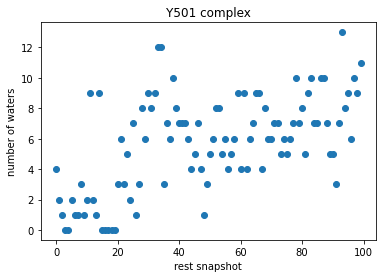

In [9]:
plt.scatter(range(len(neighbors)), [len(frame) for frame in neighbors])
plt.ylabel("number of waters")
plt.xlabel("rest snapshot")
plt.title("Y501 complex")

In [10]:
y501_waters = [len(frame) for frame in neighbors]
timeseries.statisticalInefficiency(y501_waters)


9.443424518743667

## Y501 apo (15/145)

In [3]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/15/145/"
i = 145
phase = 'apo'
htf = pickle.load(open(os.path.join(outdir, f"{i}_{phase}.pickle"), "rb"))

In [10]:
name = "tyr"
endstate = 1
is_old = False
traj_rest_solvent = make_traj(outdir, htf, i, phase, name, endstate, is_old, keep_solvent=True)

[[8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04260961]
 [8.6254     8.13210511 7.04

/scratch/lsftmp/2655116.tmpdir/ipykernel_37402/330331542.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for j, pos in tqdm_notebook(enumerate(cache)):


0it [00:00, ?it/s]

In [11]:
traj_rest_solvent.save(os.path.join(outdir, f"{i}_{phase}_Y501_rest.dcd"))
traj_rest_solvent[0].save(os.path.join(outdir, f"{i}_{phase}_Y501_rest.pdb"))

In [33]:
tyr_atoms = []
for atom in traj_rest_solvent.topology.atoms:
    if atom.residue.resSeq == 501 and atom.residue.name == 'TYR':
        if atom.name == 'OH':
            print(atom, atom.residue.resSeq, atom.index)
            tyr_atoms.append(atom.index)

TYR501-OH 501 2620


In [34]:
water_atoms = traj_rest_solvent.topology.select("water and symbol == 'O'")

In [35]:
neighbors = md.compute_neighbors(traj_rest_solvent, 0.5, tyr_atoms, haystack_indices=water_atoms)

Text(0.5, 1.0, 'Y501 apo')

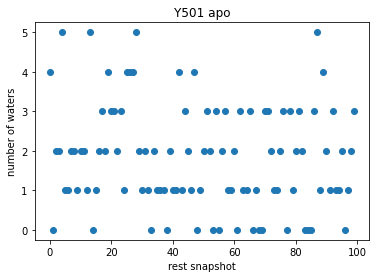

In [36]:
plt.scatter(range(len(neighbors)), [len(frame) for frame in neighbors])
plt.ylabel("number of waters")
plt.xlabel("rest snapshot")
plt.title("Y501 apo")

In [37]:
y501_waters = [len(frame) for frame in neighbors]
timeseries.statisticalInefficiency(y501_waters)


1.30002828854314

## Y501 complex (15/146)

In [3]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/15/146/"
i = 146
phase = 'complex'
htf = pickle.load(open(os.path.join(outdir, f"{i}_{phase}.pickle"), "rb"))

In [4]:
name = "tyr"
endstate = 1
is_old = False
traj_rest_solvent = make_traj(outdir, htf, i, phase, name, endstate, is_old, keep_solvent=True)

<ipython-input-2-45ff68d441e7>:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for j, pos in tqdm_notebook(enumerate(cache)):


0it [00:00, ?it/s]

ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


In [5]:
traj_rest_solvent.save(os.path.join(outdir, f"{i}_{phase}_Y501_rest.dcd"))
traj_rest_solvent[0].save(os.path.join(outdir, f"{i}_{phase}_Y501_rest.pdb"))

In [6]:
tyr_atoms = []
for atom in traj_rest_solvent.topology.atoms:
    if atom.residue.resSeq == 501 and atom.residue.name == 'TYR':
        if atom.name == 'OH':
            print(atom, atom.residue.resSeq, atom.index)
            tyr_atoms.append(atom.index)

TYR501-OH 501 2618


In [7]:
water_atoms = traj_rest_solvent.topology.select("water and symbol == 'O'")

In [8]:
neighbors = md.compute_neighbors(traj_rest_solvent, 0.5, tyr_atoms, haystack_indices=water_atoms)

<ipython-input-8-a5abb6fa0691>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  neighbors = md.compute_neighbors(traj_rest_solvent, 0.5, tyr_atoms, haystack_indices=water_atoms)


Text(0.5, 1.0, 'Y501 complex')

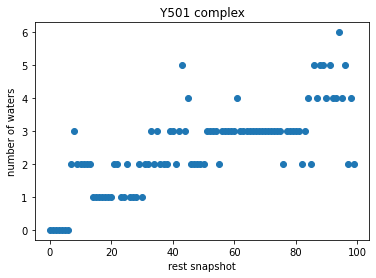

In [9]:
plt.scatter(range(len(neighbors)), [len(frame) for frame in neighbors])
plt.ylabel("number of waters")
plt.xlabel("rest snapshot")
plt.title("Y501 complex")

In [10]:
y501_waters = [len(frame) for frame in neighbors]
timeseries.statisticalInefficiency(y501_waters)


19.357594817284095

## Y501 apo (15/146)

In [3]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/15/146/"
i = 146
phase = 'apo'
htf = pickle.load(open(os.path.join(outdir, f"{i}_{phase}.pickle"), "rb"))

DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=6)
           2	LOAD_GLOBAL(arg=0, lineno=6)
           4	LOAD_METHOD(arg=1, lineno=6)
           6	LOAD_CONST(arg=1, lineno=6)
           8	CALL_METHOD(arg=1, lineno=6)
          10	STORE_FAST(arg=2, lineno=6)
          12	LOAD_FAST(arg=0, lineno=7)
          14	LOAD_CONST(arg=2, lineno=7)
          16	BINARY_SUBSCR(arg=None, lineno=7)
          18	LOAD_FAST(arg=1, lineno=7)
          20	LOAD_CONST(arg=3, lineno=7)
          22	BINARY_SUBSCR(arg=None, lineno=7)
          24	BINARY_MULTIPLY(arg=None, lineno=7)
          26	LOAD_FAST(arg=0, lineno=7)
          28	LOAD_CONST(arg=3, lineno=7)
          30	BINARY_SUBSCR(arg=None, lineno=7)
          32	LOAD_FAST(arg=1, lineno=7)
          34	LOAD_CONST(arg=2, lineno=7)
          36	BINARY_SUBSCR(arg=None, lineno=7)
          38	BINARY_MULTIPLY(arg=None, lineno=7)
          40	BINARY_SUBTRACT(arg=None, lineno=7)
          42	LOAD_FAST(arg=2, lineno=7)
          44	LO

DEBUG:numba.core.byteflow:dispatch pc=74, inst=BINARY_MULTIPLY(arg=None, lineno=8)
DEBUG:numba.core.byteflow:stack ['$60binary_multiply.27', '$66binary_subscr.30', '$72binary_subscr.33']
DEBUG:numba.core.byteflow:dispatch pc=76, inst=BINARY_SUBTRACT(arg=None, lineno=8)
DEBUG:numba.core.byteflow:stack ['$60binary_multiply.27', '$74binary_multiply.34']
DEBUG:numba.core.byteflow:dispatch pc=78, inst=LOAD_FAST(arg=2, lineno=8)
DEBUG:numba.core.byteflow:stack ['$76binary_subtract.35']
DEBUG:numba.core.byteflow:dispatch pc=80, inst=LOAD_CONST(arg=2, lineno=8)
DEBUG:numba.core.byteflow:stack ['$76binary_subtract.35', '$c78.36']
DEBUG:numba.core.byteflow:dispatch pc=82, inst=STORE_SUBSCR(arg=None, lineno=8)
DEBUG:numba.core.byteflow:stack ['$76binary_subtract.35', '$c78.36', '$const80.37']
DEBUG:numba.core.byteflow:dispatch pc=84, inst=LOAD_FAST(arg=0, lineno=9)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=86, inst=LOAD_CONST(arg=4, lineno=9)
DEBUG:numba.core.bytefl

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b7d9c75bd30>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $2load_global.0 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $4load_method.1 = getattr(value=$2load_global.0, attr=zeros)
DEBUG:numba.core.ssa:on stmt: $const6.2 = const(int, 3)
DEBUG:numba.core.ssa:on stmt: $8call_method.3 = call $4load_method.1($const6.2, func=$4load_method.1, args=[Var($const6.2, coordinate_numba.py:6)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: c = $8call_method.3
DEBUG:numba.core.ssa:on stmt: $const14.5 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $16binary_subscr.6 = static_getitem(value=a, index=1, index_var=$const14.5, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:

DEBUG:numba.core.ssa:SSA violators set()
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=14)
           2	LOAD_GLOBAL(arg=0, lineno=14)
           4	LOAD_METHOD(arg=1, lineno=14)
           6	LOAD_FAST(arg=0, lineno=14)
           8	LOAD_FAST(arg=0, lineno=14)
          10	CALL_METHOD(arg=2, lineno=14)
          12	STORE_FAST(arg=1, lineno=14)
          14	LOAD_GLOBAL(arg=0, lineno=15)
          16	LOAD_METHOD(arg=2, lineno=15)
          18	LOAD_FAST(arg=1, lineno=15)
          20	CALL_METHOD(arg=1, lineno=15)
          22	RETURN_VALUE(arg=None, lineno=15)
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=14)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=14)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_METHOD(arg=1, lineno=14)


DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=508)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=508)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_ATTR(arg=0, lineno=508)
DEBUG:numba.core.byteflow:stack ['$a2.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=UNPACK_SEQUENCE(arg=1, lineno=508)
DEBUG:numba.core.byteflow:stack ['$4load_attr.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=STORE_FAST(arg=2, lineno=508)
DEBUG:numba.core.byteflow:stack ['$6unpack_sequence.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_FAST(arg=1, lineno=509)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_ATTR(arg=0, lineno=509)
DEBUG:numba.core.byteflow:stack ['$b10.4']
DEBUG:numba.core.byteflow:dispatch pc=14, inst=UNPACK_SEQUENCE(arg=1, lineno=509)
DEBUG:numba.core.byteflow:stack ['$12load_attr.5']
DEBU

DEBUG:numba.core.ssa:on stmt: $24pred = call bool24($22compare_op.10, func=bool24, args=(Var($22compare_op.10, linalg.py:510),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $24pred, 26, 34
DEBUG:numba.core.ssa:==== SSA block analysis pass on 26
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b7d9c9aab50>
DEBUG:numba.core.ssa:on stmt: $26load_global.0 = global(ValueError: <class 'ValueError'>)
DEBUG:numba.core.ssa:on stmt: $const28.1 = const(str, incompatible array sizes for np.dot(a, b) (vector * vector))
DEBUG:numba.core.ssa:on stmt: $30call_function.2 = call $26load_global.0($const28.1, func=$26load_global.0, args=[Var($const28.1, linalg.py:511)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: <static> raise <class 'ValueError'>('incompatible array sizes for np.dot(a, b) (vector * vector)')
DEBUG:numba.core.ssa:==== SSA block analysis pass on 34
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b7d9c9aab50>
DEB

DEBUG:numba.core.ssa:on stmt: n = arg(0, name=n)
DEBUG:numba.core.ssa:on stmt: $4load_deref.1 = freevar(_maxint: 2147483647)
DEBUG:numba.core.ssa:on stmt: $6compare_op.2 = n > $4load_deref.1
DEBUG:numba.core.ssa:on stmt: bool8 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $8pred = call bool8($6compare_op.2, func=bool8, args=(Var($6compare_op.2, linalg.py:308),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $8pred, 10, 18
DEBUG:numba.core.ssa:==== SSA block analysis pass on 10
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b7d9c9d4700>
DEBUG:numba.core.ssa:on stmt: $10load_global.0 = global(OverflowError: <class 'OverflowError'>)
DEBUG:numba.core.ssa:on stmt: $const12.1 = const(str, array size too large to fit in C int)
DEBUG:numba.core.ssa:on stmt: $14call_function.2 = call $10load_global.0($const12.1, func=$10load_global.0, args=[Var($const12.1, linalg.py:309)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: <static> raise 

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=22)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=22)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_FAST(arg=0, lineno=22)
DEBUG:numba.core.byteflow:stack ['$2load_global.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=CALL_FUNCTION(arg=1, lineno=22)
DEBUG:numba.core.byteflow:stack ['$2load_global.0', '$axis4.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=STORE_FAST(arg=2, lineno=22)
DEBUG:numba.core.byteflow:stack ['$6call_function.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_GLOBAL(arg=1, lineno=23)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_CONST(arg=1, lineno=23)
DEBUG:numba.core.byteflow:stack ['$10load_global.3']
DEBUG:numba.core.byteflow:di

DEBUG:numba.core.byteflow:dispatch pc=128, inst=LOAD_FAST(arg=0, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38']
DEBUG:numba.core.byteflow:dispatch pc=130, inst=LOAD_CONST(arg=2, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38', '$axis128.39']
DEBUG:numba.core.byteflow:dispatch pc=132, inst=BINARY_SUBSCR(arg=None, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38', '$axis128.39', '$const130.40']
DEBUG:numba.core.byteflow:dispatch pc=134, inst=LOAD_FAST(arg=6, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38', '$132binary_subscr.41']
DEBUG:numba.core.byteflow:dispatch pc=136, inst=BINARY_MULTIPLY(arg=None, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38', '$132binary_subscr.41', '$sin_angle134.42']
DEBUG:numba.core.byteflow:dispatch pc=138, inst=BINARY_SUBTRACT(arg=None, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38', '$136binary_multiply.43']
DEBUG:numba.core.byteflo

DEBUG:numba.core.byteflow:stack ['$cos_angle226.85', '$232binary_subscr.88']
DEBUG:numba.core.byteflow:dispatch pc=236, inst=LOAD_FAST(arg=5, lineno=36)
DEBUG:numba.core.byteflow:stack ['$cos_angle226.85', '$232binary_subscr.88', '$const234.89']
DEBUG:numba.core.byteflow:dispatch pc=238, inst=BINARY_SUBTRACT(arg=None, lineno=36)
DEBUG:numba.core.byteflow:stack ['$cos_angle226.85', '$232binary_subscr.88', '$const234.89', '$cos_angle236.90']
DEBUG:numba.core.byteflow:dispatch pc=240, inst=BINARY_MULTIPLY(arg=None, lineno=36)
DEBUG:numba.core.byteflow:stack ['$cos_angle226.85', '$232binary_subscr.88', '$238binary_subtract.91']
DEBUG:numba.core.byteflow:dispatch pc=242, inst=BINARY_ADD(arg=None, lineno=36)
DEBUG:numba.core.byteflow:stack ['$cos_angle226.85', '$240binary_multiply.92']
DEBUG:numba.core.byteflow:dispatch pc=244, inst=LOAD_FAST(arg=7, lineno=36)
DEBUG:numba.core.byteflow:stack ['$242binary_add.93']
DEBUG:numba.core.byteflow:dispatch pc=246, inst=LOAD_CONST(arg=12, lineno=36)
D

DEBUG:numba.core.byteflow:stack ['$334binary_subscr.136', '$axis336.137', '$const338.138']
DEBUG:numba.core.byteflow:dispatch pc=342, inst=BINARY_MULTIPLY(arg=None, lineno=40)
DEBUG:numba.core.byteflow:stack ['$334binary_subscr.136', '$340binary_subscr.139']
DEBUG:numba.core.byteflow:dispatch pc=344, inst=LOAD_CONST(arg=6, lineno=40)
DEBUG:numba.core.byteflow:stack ['$342binary_multiply.140']
DEBUG:numba.core.byteflow:dispatch pc=346, inst=LOAD_FAST(arg=5, lineno=40)
DEBUG:numba.core.byteflow:stack ['$342binary_multiply.140', '$const344.141']
DEBUG:numba.core.byteflow:dispatch pc=348, inst=BINARY_SUBTRACT(arg=None, lineno=40)
DEBUG:numba.core.byteflow:stack ['$342binary_multiply.140', '$const344.141', '$cos_angle346.142']
DEBUG:numba.core.byteflow:dispatch pc=350, inst=BINARY_MULTIPLY(arg=None, lineno=40)
DEBUG:numba.core.byteflow:stack ['$342binary_multiply.140', '$348binary_subtract.143']
DEBUG:numba.core.byteflow:dispatch pc=352, inst=LOAD_FAST(arg=0, lineno=40)
DEBUG:numba.core.byt

DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>,
            {'$phi18.0': {('$16get_iter.6',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi20.0': {('$16get_iter.6',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi20.1': {('$18for_iter.2',
                           State(pc_initial=18 nstack_initial=1))}})
DEBUG:numba.core.byteflow:keep phismap: {'$phi18.0': {('$16get_iter.6', State(pc_initial=0 nstack_initial=0))},
 '$phi20.1': {('$18for_iter.2', State(pc_initial=18 nstack_initial=1))}}
DEBUG:numba.core.byteflow:new_out: defaultdict(<class 'dict'>,
            {State(pc_initial=0 nstack_initial=0): {'$phi18.0': '$16get_iter.6'},
             State(pc_initial=18 nstack_initial=1): {'$phi20.1': '$18for_iter.2'}})
DEBUG:numba.core.byteflow:----------------------DONE Prune PHIs-----------------------
DEBUG:numba.core.byteflow:block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(in

DEBUG:numba.core.interpreter:label 0:
    axis = arg(0, name=axis)                 ['axis']
    angle = arg(1, name=angle)               ['angle']
    $2load_global.0 = global(_norm: CPUDispatcher(<function _norm at 0x2b7d9c924ca0>)) ['$2load_global.0']
    $6call_function.2 = call $2load_global.0(axis, func=$2load_global.0, args=[Var(axis, coordinate_numba.py:22)], kws=(), vararg=None) ['$2load_global.0', '$6call_function.2', 'axis']
    axis_norm = $6call_function.2            ['$6call_function.2', 'axis_norm']
    $10load_global.3 = global(range: <class 'range'>) ['$10load_global.3']
    $const12.4 = const(int, 3)               ['$const12.4']
    $14call_function.5 = call $10load_global.3($const12.4, func=$10load_global.3, args=[Var($const12.4, coordinate_numba.py:23)], kws=(), vararg=None) ['$10load_global.3', '$14call_function.5', '$const12.4']
    $16get_iter.6 = getiter(value=$14call_function.5) ['$14call_function.5', '$16get_iter.6']
    $phi18.0 = $16get_iter.6                

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b7d9ca3e580>
DEBUG:numba.core.ssa:on stmt: axis = arg(0, name=axis)
DEBUG:numba.core.ssa:on stmt: angle = arg(1, name=angle)
DEBUG:numba.core.ssa:on stmt: $2load_global.0 = global(_norm: CPUDispatcher(<function _norm at 0x2b7d9c924ca0>))
DEBUG:numba.core.ssa:on stmt: $6call_function.2 = call $2load_global.0(axis, func=$2load_global.0, args=[Var(axis, coordinate_numba.py:22)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: axis_norm = $6call_function.2
DEBUG:numba.core.ssa:on stmt: $10load_global.3 = global(range: <class 'range'>)
DEBUG:numba.core.ssa:on stmt: $const12.4 = const(int, 3)
DEBUG:numba.core.ssa:on stmt: $14call_function.5 = call $10load_global.3($const12.4, func=$10load_global.3, args=[Var($const12.4, coordinate_numba.py:23)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $16get_iter.6 = getiter(value=$14call_function.5)
DEBUG:numba.co

DEBUG:numba.core.ssa:on stmt: $const194.70 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $196binary_subscr.71 = static_getitem(value=axis, index=0, index_var=$const194.70, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $198binary_multiply.72 = $190binary_subscr.68 * $196binary_subscr.71
DEBUG:numba.core.ssa:on stmt: $const200.73 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $204binary_subtract.75 = $const200.73 - cos_angle
DEBUG:numba.core.ssa:on stmt: $206binary_multiply.76 = $198binary_multiply.72 * $204binary_subtract.75
DEBUG:numba.core.ssa:on stmt: $const210.78 = const(int, 2)
DEBUG:numba.core.ssa:on stmt: $212binary_subscr.79 = static_getitem(value=axis, index=2, index_var=$const210.78, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $216binary_multiply.81 = $212binary_subscr.79 * sin_angle
DEBUG:numba.core.ssa:on stmt: $218binary_add.82 = $206binary_multiply.76 + $216binary_multiply.81
DEBUG:numba.core.ssa:on stmt: $const_1.1 = const(int, 1)
DEBU

DEBUG:numba.core.ssa:SSA violators set()
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=22)
           2	LOAD_FAST(arg=0, lineno=22)
           4	LOAD_CONST(arg=1, lineno=1)
           6	BINARY_POWER(arg=None, lineno=1)
           8	RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=22)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=22)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_CONST(arg=1, lineno=1)
DEBUG:numba.core.byteflow:stack ['$axis_12.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_POWER(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$axis_12.0', '$const4.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$

DEBUG:numba.core.byteflow:stack ['$6call_function.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_DEREF(arg=1, lineno=218)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_FAST(arg=0, lineno=218)
DEBUG:numba.core.byteflow:stack ['$10load_deref.3']
DEBUG:numba.core.byteflow:dispatch pc=14, inst=CALL_FUNCTION(arg=1, lineno=218)
DEBUG:numba.core.byteflow:stack ['$10load_deref.3', '$a12.4']
DEBUG:numba.core.byteflow:dispatch pc=16, inst=STORE_FAST(arg=0, lineno=218)
DEBUG:numba.core.byteflow:stack ['$14call_function.5']
DEBUG:numba.core.byteflow:dispatch pc=18, inst=LOAD_FAST(arg=1, lineno=219)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=20, inst=LOAD_CONST(arg=2, lineno=219)
DEBUG:numba.core.byteflow:stack ['$b18.6']
DEBUG:numba.core.byteflow:dispatch pc=22, inst=COMPARE_OP(arg=0, lineno=219)
DEBUG:numba.core.byteflow:stack ['$b18.6', '$const20.7']
DEBUG:numba.core.byteflow:dispatch pc=24, inst=POP_JUMP_IF_FALSE(ar

DEBUG:numba.core.byteflow:stack ['$exp130.0']
DEBUG:numba.core.byteflow:dispatch pc=134, inst=COMPARE_OP(arg=3, lineno=238)
DEBUG:numba.core.byteflow:stack ['$exp130.0', '$const132.1']
DEBUG:numba.core.byteflow:dispatch pc=136, inst=POP_JUMP_IF_FALSE(arg=172, lineno=238)
DEBUG:numba.core.byteflow:stack ['$134compare_op.2']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=138, stack=(), blockstack=(), npush=0), Edge(pc=172, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=60 nstack_initial=0), State(pc_initial=76 nstack_initial=0), State(pc_initial=138 nstack_initial=0), State(pc_initial=172 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=60, inst=LOAD_DEREF(arg=2, lineno=226)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=62, inst=POP_JUMP_IF_FALSE(arg=68, lineno=226)
DEBUG:numba.core.byteflow:stack ['$60load_deref.0']
DEBUG:numba.core.byteflow:end state. edges=[Edge(

DEBUG:numba.core.byteflow:dispatch pc=160, inst=STORE_FAST(arg=4, lineno=241)
DEBUG:numba.core.byteflow:stack ['$158inplace_rshift.2']
DEBUG:numba.core.byteflow:dispatch pc=162, inst=LOAD_FAST(arg=0, lineno=242)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=164, inst=LOAD_FAST(arg=0, lineno=242)
DEBUG:numba.core.byteflow:stack ['$a162.3']
DEBUG:numba.core.byteflow:dispatch pc=166, inst=INPLACE_MULTIPLY(arg=None, lineno=242)
DEBUG:numba.core.byteflow:stack ['$a162.3', '$a164.4']
DEBUG:numba.core.byteflow:dispatch pc=168, inst=STORE_FAST(arg=0, lineno=242)
DEBUG:numba.core.byteflow:stack ['$166inplace_multiply.5']
DEBUG:numba.core.byteflow:dispatch pc=170, inst=JUMP_ABSOLUTE(arg=130, lineno=242)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=130, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=176 nstack_initial=0), State(pc_initial=184 nstack_initial=0), State(pc_initial=92 n

DEBUG:numba.core.byteflow:block_infos State(pc_initial=84 nstack_initial=0):
AdaptBlockInfo(insts=((84, {'res': '$a84.0'}), (86, {'res': '$const86.1'}), (88, {'lhs': '$a84.0', 'rhs': '$const86.1', 'res': '$88compare_op.2'}), (90, {'pred': '$88compare_op.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={92: (), 106: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=92 nstack_initial=0):
AdaptBlockInfo(insts=((92, {'res': '$const92.0'}), (94, {'retval': '$const92.0', 'castval': '$94return_value.1'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=98 nstack_initial=0):
AdaptBlockInfo(insts=((98, {'res': '$const98.0'}), (100, {'value': '$const98.0'}), (102, {'res': '$b102.1'}), (104, {'value': '$b102.1'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={106: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=106 nstack_i

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b7d9caaf790>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $2load_deref.0 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: $const4.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $6call_function.2 = call $2load_deref.0($const4.1, func=$2load_deref.0, args=[Var($const4.1, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: r = $6call_function.2
DEBUG:numba.core.ssa:on stmt: $10load_deref.3 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: $14call_function.5 = call $10load_deref.3(a, func=$10load_deref.3, args=[Var(a, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: a.1 = $14call_function.5
DEBUG:numba.core.ssa:on stmt: $const20.7 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $22compare_op.8 = b < $const20.7
DEBUG:numba.core.ssa:on st

DEBUG:numba.core.ssa:SSA violators {'r', 'invert', 'exp', 'a.1'}
DEBUG:numba.core.ssa:Fix SSA violator on var r
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b7d9caaf790>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $2load_deref.0 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: $const4.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $6call_function.2 = call $2load_deref.0($const4.1, func=$2load_deref.0, args=[Var($const4.1, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: r = $6call_function.2
DEBUG:numba.core.ssa:first assign: r
DEBUG:numba.core.ssa:replaced with: r = $6call_function.2
DEBUG:numba.core.ssa:on stmt: $10load_deref.3 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: $14call_function.5 = call $10load_deref.3(a, func=$10load_deref.3, args=[Var(a, numbers.py:217)], kws=(), vararg=Non

DEBUG:numba.core.ssa:on stmt: $186return_value.1 = cast(value=r)
DEBUG:numba.core.ssa:on stmt: return $186return_value.1
DEBUG:numba.core.ssa:Replaced assignments: defaultdict(<class 'list'>,
            {0: [<numba.core.ir.Assign object at 0x2b7d9cab2eb0>],
             146: [<numba.core.ir.Assign object at 0x2b7d9cab5e50>]})
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b7d9cab5f70>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $2load_deref.0 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: $const4.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $6call_function.2 = call $2load_deref.0($const4.1, func=$2load_deref.0, args=[Var($const4.1, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: r = $6call_function.2
DEBUG:numba.core.ssa:on stmt: $10load_deref.3 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt:

DEBUG:numba.core.ssa:on stmt: r.1 = $150inplace_multiply.2
DEBUG:numba.core.ssa:on stmt: jump 154
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 154
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b7d9cab5f70>
DEBUG:numba.core.ssa:on stmt: $const156.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $158inplace_rshift.2 = inplace_binop(fn=<built-in function irshift>, immutable_fn=<built-in function rshift>, lhs=exp, rhs=$const156.1, static_lhs=Undefined, static_rhs=Undefined)
DEBUG:numba.core.ssa:on stmt: exp = $158inplace_rshift.2
DEBUG:numba.core.ssa:on stmt: $166inplace_multiply.5 = inplace_binop(fn=<built-in function imul>, immutable_fn=<built-in function mul>, lhs=a.1, rhs=a.1, static_lhs=Undefined, static_rhs=Undefined)
DEBUG:numba.core.ssa:on stmt: a.1 = $166inplace_multiply.5
DEBUG:numba.core.ssa:on stmt: jump 130
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 172
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b7d9cab5f70>
DEB

DEBUG:numba.core.ssa:on stmt: $136pred = call bool136($134compare_op.2, func=bool136, args=(Var($134compare_op.2, numbers.py:238),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $136pred, 138, 172
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 138
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b7d9cae48e0>
DEBUG:numba.core.ssa:on stmt: $const140.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $142binary_and.2 = exp & $const140.1
DEBUG:numba.core.ssa:on stmt: bool144 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $144pred = call bool144($142binary_and.2, func=bool144, args=(Var($142binary_and.2, numbers.py:239),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $144pred, 146, 154
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 146
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b7d9cae48e0>
DEBUG:numba.core.ssa:on stmt: $150inplace_multiply.2 = inplace_binop(fn=<built-in function imul>, 

DEBUG:numba.core.ssa:on stmt: r.2 = phi(incoming_values=[Var(r, numbers.py:217), Var(r.3, numbers.py:240)], incoming_blocks=[106, 154])
DEBUG:numba.core.ssa:on stmt: $const132.1 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $134compare_op.2 = exp != $const132.1
DEBUG:numba.core.ssa:on stmt: bool136 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $136pred = call bool136($134compare_op.2, func=bool136, args=(Var($134compare_op.2, numbers.py:238),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $136pred, 138, 172
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 138
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b7d9caf2ca0>
DEBUG:numba.core.ssa:on stmt: $const140.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $142binary_and.2 = exp & $const140.1
DEBUG:numba.core.ssa:on stmt: bool144 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $144pred = call bool144($142binary_and.2, func=bool144, args=(Var($142binary_and.2, numbers.py:2

DEBUG:numba.core.ssa:on stmt: $const108.1 = const(int, 65536)
DEBUG:numba.core.ssa:on stmt: $110compare_op.2 = exp > $const108.1
DEBUG:numba.core.ssa:on stmt: bool112 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $112pred = call bool112($110compare_op.2, func=bool112, args=(Var($110compare_op.2, numbers.py:235),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $112pred, 114, 130
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 114
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b7d9cab2b80>
DEBUG:numba.core.ssa:on stmt: $114load_global.0 = global(math: <module 'math' from '/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/lib-dynload/math.cpython-38-x86_64-linux-gnu.so'>)
DEBUG:numba.core.ssa:on stmt: $116load_method.1 = getattr(value=$114load_global.0, attr=pow)
DEBUG:numba.core.ssa:on stmt: $120load_global.3 = global(float: <class 'float'>)
DEBUG:numba.core.ssa:on stmt: $124call_function.5 = call $120load_global.3(b, fu

DEBUG:numba.core.ssa:on stmt: jump 106
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 98
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b7d9cae48e0>
DEBUG:numba.core.ssa:on stmt: $const98.0 = const(bool, False)
DEBUG:numba.core.ssa:on stmt: invert.1 = $const98.0
DEBUG:numba.core.ssa:on stmt: exp.1 = b
DEBUG:numba.core.ssa:on stmt: jump 106
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 106
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b7d9cae48e0>
DEBUG:numba.core.ssa:on stmt: invert.2 = phi(incoming_values=[Var(invert, numbers.py:220), Var(invert.1, numbers.py:233)], incoming_blocks=[48, 98])
DEBUG:numba.core.ssa:on stmt: $const108.1 = const(int, 65536)
DEBUG:numba.core.ssa:on stmt: $110compare_op.2 = exp > $const108.1
DEBUG:numba.core.ssa:find_def var='exp' stmt=$110compare_op.2 = exp > $const108.1
DEBUG:numba.core.ssa:find_def_from_top label 106
DEBUG:numba.core.ssa:insert phi node exp.3 = phi(incoming_values=[], incoming_bloc

DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $2load_deref.0 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: $const4.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $6call_function.2 = call $2load_deref.0($const4.1, func=$2load_deref.0, args=[Var($const4.1, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: r = $6call_function.2
DEBUG:numba.core.ssa:on stmt: $10load_deref.3 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: $14call_function.5 = call $10load_deref.3(a, func=$10load_deref.3, args=[Var(a, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: a.1 = $14call_function.5
DEBUG:numba.core.ssa:first assign: a.1
DEBUG:numba.core.ssa:replaced with: a.1 = $14call_function.5
DEBUG:numba.core.ssa:on stmt: $const20.7 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $22compare_op.8 = b < $const20.7
DEBUG:numba.core.ssa:on stmt: bool24 = global(bool: <class 'bool'>)
DEB

DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b7d9cab5490>
DEBUG:numba.core.ssa:on stmt: $const176.0 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $180binary_true_divide.2 = $const176.0 / r.2
DEBUG:numba.core.ssa:on stmt: $182return_value.3 = cast(value=$180binary_true_divide.2)
DEBUG:numba.core.ssa:on stmt: return $182return_value.3
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 184
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b7d9cab5490>
DEBUG:numba.core.ssa:on stmt: $186return_value.1 = cast(value=r.2)
DEBUG:numba.core.ssa:on stmt: return $186return_value.1
DEBUG:numba.core.ssa:Replaced assignments: defaultdict(<class 'list'>,
            {0: [<numba.core.ir.Assign object at 0x2b7d9caf2c40>],
             154: [<numba.core.ir.Assign object at 0x2b7d9caafd60>]})
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b7d9cab2b80>
DEBUG:numba.core.ss

DEBUG:numba.core.ssa:find_def_from_top label 146
DEBUG:numba.core.ssa:idom 138 from label 146
DEBUG:numba.core.ssa:find_def_from_bottom label 138
DEBUG:numba.core.ssa:find_def_from_top label 138
DEBUG:numba.core.ssa:idom 130 from label 138
DEBUG:numba.core.ssa:find_def_from_bottom label 130
DEBUG:numba.core.ssa:find_def_from_top label 130
DEBUG:numba.core.ssa:insert phi node a.1.2 = phi(incoming_values=[], incoming_blocks=[]) at 130
DEBUG:numba.core.ssa:find_def_from_bottom label 106
DEBUG:numba.core.ssa:find_def_from_top label 106
DEBUG:numba.core.ssa:idom 0 from label 106
DEBUG:numba.core.ssa:find_def_from_bottom label 0
DEBUG:numba.core.ssa:incoming_def a.1 = $14call_function.5
DEBUG:numba.core.ssa:find_def_from_bottom label 154
DEBUG:numba.core.ssa:incoming_def a.1.1 = $166inplace_multiply.5
DEBUG:numba.core.ssa:replaced with: $150inplace_multiply.2 = inplace_binop(fn=<built-in function imul>, immutable_fn=<built-in function mul>, lhs=r.2, rhs=a.1.2, static_lhs=Undefined, static_rh

DEBUG:numba.core.byteflow:stack ['$const14.0']
DEBUG:numba.core.byteflow:dispatch pc=18, inst=LOAD_FAST(arg=2, lineno=211)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=20, inst=LOAD_FAST(arg=0, lineno=211)
DEBUG:numba.core.byteflow:stack ['$dest_ndim18.1']
DEBUG:numba.core.byteflow:dispatch pc=22, inst=BINARY_SUBTRACT(arg=None, lineno=211)
DEBUG:numba.core.byteflow:stack ['$dest_ndim18.1', '$src_ndim20.2']
DEBUG:numba.core.byteflow:dispatch pc=24, inst=STORE_FAST(arg=5, lineno=211)
DEBUG:numba.core.byteflow:stack ['$22binary_subtract.3']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=26, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=26 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=26, inst=LOAD_FAST(arg=4, lineno=212)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=28, inst=LOAD_FAST(arg=0, lineno=212)
DEBUG:numba.core.byteflow:stack 

DEBUG:numba.core.byteflow:dispatch pc=94, inst=LOAD_FAST(arg=6, lineno=225)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=96, inst=LOAD_FAST(arg=3, lineno=225)
DEBUG:numba.core.byteflow:stack ['$src_dim_size94.0']
DEBUG:numba.core.byteflow:dispatch pc=98, inst=LOAD_FAST(arg=5, lineno=225)
DEBUG:numba.core.byteflow:stack ['$src_dim_size94.0', '$dest_shape96.1']
DEBUG:numba.core.byteflow:dispatch pc=100, inst=STORE_SUBSCR(arg=None, lineno=225)
DEBUG:numba.core.byteflow:stack ['$src_dim_size94.0', '$dest_shape96.1', '$dest_index98.2']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=102, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=102 nstack_initial=0), State(pc_initial=74 nstack_initial=0), State(pc_initial=102 nstack_initial=0), State(pc_initial=26 nstack_initial=0), State(pc_initial=102 nstack_initial=0)])
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=74 nstack_initial=0), State(pc_initial=102 

DEBUG:numba.core.byteflow:block_infos State(pc_initial=120 nstack_initial=0):
AdaptBlockInfo(insts=((120, {'res': '$dest_index120.0'}), (122, {'retval': '$dest_index120.0', 'castval': '$122return_value.1'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
DEBUG:numba.core.interpreter:label 0:
    src_ndim = arg(0, name=src_ndim)         ['src_ndim']
    src_shape = arg(1, name=src_shape)       ['src_shape']
    dest_ndim = arg(2, name=dest_ndim)       ['dest_ndim']
    dest_shape = arg(3, name=dest_shape)     ['dest_shape']
    $6compare_op.2 = src_ndim > dest_ndim    ['$6compare_op.2', 'dest_ndim', 'src_ndim']
    bool8 = global(bool: <class 'bool'>)     ['bool8']
    $8pred = call bool8($6compare_op.2, func=bool8, args=(Var($6compare_op.2, npyimpl.py:205),), kws=(), vararg=None) ['$6compare_op.2', '$8pred', 'bool8']
    branch $8pred, 10, 14                    ['$8pred']
label 10:
    $const10.0 = const(int, 0)               ['$const10.0']
    $12retu

DEBUG:numba.core.ssa:on stmt: $54compare_op.8 = dest_dim_size != $const52.7
DEBUG:numba.core.ssa:on stmt: bool56 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $56pred = call bool56($54compare_op.8, func=bool56, args=(Var($54compare_op.8, npyimpl.py:217),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $56pred, 58, 86
DEBUG:numba.core.ssa:==== SSA block analysis pass on 58
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b7d9caa8730>
DEBUG:numba.core.ssa:on stmt: $62compare_op.2 = src_dim_size != dest_dim_size
DEBUG:numba.core.ssa:on stmt: bool64 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $64pred = call bool64($62compare_op.2, func=bool64, args=(Var($62compare_op.2, npyimpl.py:221),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $64pred, 66, 102
DEBUG:numba.core.ssa:==== SSA block analysis pass on 66
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b7d9caa8730>
DEBUG:numba.c

DEBUG:numba.core.ssa:on stmt: branch $8pred, 10, 14
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 10
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b7d9cab2ca0>
DEBUG:numba.core.ssa:on stmt: $const10.0 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $12return_value.1 = cast(value=$const10.0)
DEBUG:numba.core.ssa:on stmt: return $12return_value.1
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 14
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b7d9cab2ca0>
DEBUG:numba.core.ssa:on stmt: $const14.0 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: src_index = $const14.0
DEBUG:numba.core.ssa:first assign: src_index
DEBUG:numba.core.ssa:replaced with: src_index = $const14.0
DEBUG:numba.core.ssa:on stmt: $22binary_subtract.3 = dest_ndim - src_ndim
DEBUG:numba.core.ssa:on stmt: dest_index = $22binary_subtract.3
DEBUG:numba.core.ssa:on stmt: jump 26
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 26
DEBUG:numba.core.ssa:Running <nu

DEBUG:numba.core.ssa:replaced with: $30compare_op.2 = src_index.2 < src_ndim
DEBUG:numba.core.ssa:on stmt: bool32 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $32pred = call bool32($30compare_op.2, func=bool32, args=(Var($30compare_op.2, npyimpl.py:212),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $32pred, 34, 120
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 34
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b7d9caf7f10>
DEBUG:numba.core.ssa:on stmt: $38binary_subscr.2 = getitem(value=src_shape, index=src_index, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:find_def var='src_index' stmt=$38binary_subscr.2 = getitem(value=src_shape, index=src_index, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:find_def_from_top label 34
DEBUG:numba.core.ssa:idom 26 from label 34
DEBUG:numba.core.ssa:find_def_from_bottom label 26
DEBUG:numba.core.ssa:replaced with: $38binary_subscr.2 = getitem(value=src_shape, index=src_index.2, 

DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b7d9caa1df0>
DEBUG:numba.core.ssa:on stmt: $38binary_subscr.2 = getitem(value=src_shape, index=src_index.2, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: src_dim_size = $38binary_subscr.2
DEBUG:numba.core.ssa:on stmt: $46binary_subscr.5 = getitem(value=dest_shape, index=dest_index, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: dest_dim_size = $46binary_subscr.5
DEBUG:numba.core.ssa:on stmt: $const52.7 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $54compare_op.8 = dest_dim_size != $const52.7
DEBUG:numba.core.ssa:on stmt: bool56 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $56pred = call bool56($54compare_op.8, func=bool56, args=(Var($54compare_op.8, npyimpl.py:217),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $56pred, 58, 86
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 58
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at

DEBUG:numba.core.ssa:on stmt: bool56 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $56pred = call bool56($54compare_op.8, func=bool56, args=(Var($54compare_op.8, npyimpl.py:217),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $56pred, 58, 86
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 58
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b7d9cab5bb0>
DEBUG:numba.core.ssa:on stmt: $62compare_op.2 = src_dim_size != dest_dim_size
DEBUG:numba.core.ssa:on stmt: bool64 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $64pred = call bool64($62compare_op.2, func=bool64, args=(Var($62compare_op.2, npyimpl.py:221),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $64pred, 66, 102
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 66
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b7d9cab5bb0>
DEBUG:numba.core.ssa:on stmt: $const68.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $70compare_op.2 = 

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=47)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=3, lineno=47)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_CONST(arg=1, lineno=47)
DEBUG:numba.core.byteflow:stack ['$internal_coordinates2.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_SUBSCR(arg=None, lineno=47)
DEBUG:numba.core.byteflow:stack ['$internal_coordinates2.0', '$const4.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=STORE_FAST(arg=4, lineno=47)
DEBUG:numba.core.byteflow:stack ['$6binary_subscr.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_FAST(arg=3, lineno=48)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_CONST(arg=2, lineno=48)
DEBUG:numba.core.byteflow:stack ['$internal_coordinates10.3']


DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=120, inst=STORE_FAST(arg=16, lineno=68)
DEBUG:numba.core.byteflow:stack ['$a_u118.46']
DEBUG:numba.core.byteflow:dispatch pc=122, inst=LOAD_GLOBAL(arg=2, lineno=69)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=124, inst=LOAD_FAST(arg=16, lineno=69)
DEBUG:numba.core.byteflow:stack ['$122load_global.47']
DEBUG:numba.core.byteflow:dispatch pc=126, inst=LOAD_FAST(arg=6, lineno=69)
DEBUG:numba.core.byteflow:stack ['$122load_global.47', '$torsion_axis124.48']
DEBUG:numba.core.byteflow:dispatch pc=128, inst=LOAD_GLOBAL(arg=3, lineno=69)
DEBUG:numba.core.byteflow:stack ['$122load_global.47', '$torsion_axis124.48', '$phi126.49']
DEBUG:numba.core.byteflow:dispatch pc=130, inst=LOAD_ATTR(arg=5, lineno=69)
DEBUG:numba.core.byteflow:stack ['$122load_global.47', '$torsion_axis124.48', '$phi126.49', '$128load_global.50']
DEBUG:numba.core.byteflow:dispatch pc=132, inst=BINARY_ADD(arg=None, lineno=69)
D

DEBUG:numba.core.interpreter:label 0:
    bond_position = arg(0, name=bond_position) ['bond_position']
    angle_position = arg(1, name=angle_position) ['angle_position']
    torsion_position = arg(2, name=torsion_position) ['torsion_position']
    internal_coordinates = arg(3, name=internal_coordinates) ['internal_coordinates']
    $const4.1 = const(int, 0)                ['$const4.1']
    $6binary_subscr.2 = getitem(value=internal_coordinates, index=$const4.1, fn=<built-in function getitem>) ['$6binary_subscr.2', '$const4.1', 'internal_coordinates']
    r = $6binary_subscr.2                    ['$6binary_subscr.2', 'r']
    $const12.4 = const(int, 1)               ['$const12.4']
    $14binary_subscr.5 = getitem(value=internal_coordinates, index=$const12.4, fn=<built-in function getitem>) ['$14binary_subscr.5', '$const12.4', 'internal_coordinates']
    theta = $14binary_subscr.5               ['$14binary_subscr.5', 'theta']
    $const20.7 = const(int, 2)               ['$const20.7']
 

DEBUG:numba.core.ssa:on stmt: phi = $22binary_subscr.8
DEBUG:numba.core.ssa:on stmt: $30binary_subtract.11 = angle_position - bond_position
DEBUG:numba.core.ssa:on stmt: a = $30binary_subtract.11
DEBUG:numba.core.ssa:on stmt: $38binary_subtract.14 = angle_position - torsion_position
DEBUG:numba.core.ssa:on stmt: b = $38binary_subtract.14
DEBUG:numba.core.ssa:on stmt: $44load_global.16 = global(_norm: CPUDispatcher(<function _norm at 0x2b7d9c924ca0>))
DEBUG:numba.core.ssa:on stmt: $48call_function.18 = call $44load_global.16(a, func=$44load_global.16, args=[Var(a, coordinate_numba.py:50)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $50binary_true_divide.19 = a / $48call_function.18
DEBUG:numba.core.ssa:on stmt: a_u = $50binary_true_divide.19
DEBUG:numba.core.ssa:on stmt: $56load_global.21 = global(_norm: CPUDispatcher(<function _norm at 0x2b7d9c924ca0>))
DEBUG:numba.core.ssa:on stmt: $60call_function.23 = call $56load_global.21(b, func=$56load_global.21, args=[Var(b, coordinate_

DEBUG:numba.core.ssa:SSA violators set()
/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/perses-0.9.1+43.g2ab680c.dirty-py3.8.egg/perses/rjmc/coordinate_numba.py:65: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  d_ang = np.dot(angle_rotation_matrix, d_r)
/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/perses-0.9.1+43.g2ab680c.dirty-py3.8.egg/perses/rjmc/coordinate_numba.py:71: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  d_torsion = np.dot(torsion_rotation_matrix, d_ang)
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=47)
           2	LOAD_FAST(arg=0, lineno=47)
           4	LOAD_FAST(arg=1, lineno=47)
           6	BINARY_SUBTRACT(arg=None, lineno=1)
           8	RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=

DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=1, lineno=50)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_FAST(arg=0, lineno=53)
DEBUG:numba.core.byteflow:stack ['$a_12.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_TRUE_DIVIDE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$a_12.0', '$_48call_function_18_14.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$6binary_true_divide.2']
DEBUG:numba.core.byteflow:end state. edges=[]
DEBUG:numba.core.byteflow:-------------------------Prune PHIs-------------------------
DEBUG:numba.core.byteflow:Used_phis: defaultdict(<class 'set'>, {State(pc_initial=0 nstack_initial=0): set()})
DEBUG:numba.core.byteflow:defmap: {}
DEBUG:numba.core.byteflow:phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byt

DEBUG:numba.core.interpreter:label 0:
    a_u_1 = arg(0, name=a_u_1)               ['a_u_1']
    r_1 = arg(1, name=r_1)                   ['r_1']
    $6binary_multiply.2 = r_1 * a_u_1        ['$6binary_multiply.2', 'a_u_1', 'r_1']
    $8return_value.3 = cast(value=$6binary_multiply.2) ['$6binary_multiply.2', '$8return_value.3']
    return $8return_value.3                  ['$8return_value.3']

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b7d9cd70820>
DEBUG:numba.core.ssa:on stmt: a_u_1 = arg(0, name=a_u_1)
DEBUG:numba.core.ssa:on stmt: r_1 = arg(1, name=r_1)
DEBUG:numba.core.ssa:on stmt: $6binary_multiply.2 = r_1 * a_u_1
DEBUG:numba.core.ssa:on stmt: $8return_value.3 = cast(value=$6binary_multiply.2)
DEBUG:numba.core.ssa:on stmt: return $8return_value.3
DEBUG:numba.core.ssa:defs defaultdict(<class 'list'>,
            {'$6binary_multiply.2': [<numba.core.ir.Assign object at 0x2b7d9cd74c40>],
        

DEBUG:numba.core.byteflow:stack ['$24compare_op.11']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=28, stack=(), blockstack=(), npush=0), Edge(pc=44, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=28 nstack_initial=0), State(pc_initial=44 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=28, inst=LOAD_GLOBAL(arg=1, lineno=488)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=30, inst=LOAD_METHOD(arg=2, lineno=488)
DEBUG:numba.core.byteflow:stack ['$28load_global.0']
DEBUG:numba.core.byteflow:dispatch pc=32, inst=LOAD_FAST(arg=2, lineno=488)
DEBUG:numba.core.byteflow:stack ['$30load_method.1']
DEBUG:numba.core.byteflow:dispatch pc=34, inst=BUILD_TUPLE(arg=1, lineno=488)
DEBUG:numba.core.byteflow:stack ['$30load_method.1', '$m32.2']
DEBUG:numba.core.byteflow:dispatch pc=36, inst=LOAD_FAST(arg=0, lineno=488)
DEBUG:numba.core.byteflow:stack ['$30load_method.1', '$34build

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b7d9ce2fd90>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $4load_attr.1 = getattr(value=a, attr=shape)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.4 = exhaust_iter(value=$4load_attr.1, count=2)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.2 = static_getitem(value=$6unpack_sequence.4, index=0, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.3 = static_getitem(value=$6unpack_sequence.4, index=1, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: m = $6unpack_sequence.2
DEBUG:numba.core.ssa:on stmt: n = $6unpack_sequence.3
DEBUG:numba.core.ssa:on stmt: $14load_attr.6 = getattr(value=b, attr=shape)
DEBUG:numba.core.ssa:on stmt: $16unpack_sequence.8 = exhaust_iter(value=$14load_attr.6, count=1)
DEBU

DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=571)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_ATTR(arg=0, lineno=571)
DEBUG:numba.core.byteflow:stack ['$a2.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=UNPACK_SEQUENCE(arg=2, lineno=571)
DEBUG:numba.core.byteflow:stack ['$4load_attr.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=STORE_FAST(arg=3, lineno=571)
DEBUG:numba.core.byteflow:stack ['$6unpack_sequence.3', '$6unpack_sequence.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=STORE_FAST(arg=4, lineno=571)
DEBUG:numba.core.byteflow:stack ['$6unpack_sequence.3']
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_FAST(arg=1, lineno=572)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=14, inst=LOAD_ATTR(arg=0, lineno=572)
DEBUG:numba.core.byteflow:stack ['$b12.5']
DEBUG:numba.core.byteflow:dispatch pc=16, inst=UNPACK_SEQUENCE(arg=1, lineno=572)
DEBUG:n

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b7d9ceacf40>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: out = arg(2, name=out)
DEBUG:numba.core.ssa:on stmt: $4load_attr.1 = getattr(value=a, attr=shape)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.4 = exhaust_iter(value=$4load_attr.1, count=2)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.2 = static_getitem(value=$6unpack_sequence.4, index=0, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.3 = static_getitem(value=$6unpack_sequence.4, index=1, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: m = $6unpack_sequence.2
DEBUG:numba.core.ssa:on stmt: _n = $6unpack_sequence.3
DEBUG:numba.core.ssa:on stmt: $14load_attr.6 = getattr(value=b, attr=shape)
DEBUG:numba.core.ssa:on stmt: $16unpack_sequenc

DEBUG:numba.core.interpreter:label 0:
    bond_position_2 = arg(0, name=bond_position_2) ['bond_position_2']
    d_torsion_1 = arg(1, name=d_torsion_1)   ['d_torsion_1']
    $6binary_add.2 = bond_position_2 + d_torsion_1 ['$6binary_add.2', 'bond_position_2', 'd_torsion_1']
    $8return_value.3 = cast(value=$6binary_add.2) ['$6binary_add.2', '$8return_value.3']
    return $8return_value.3                  ['$8return_value.3']

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b7d9cfbdbe0>
DEBUG:numba.core.ssa:on stmt: bond_position_2 = arg(0, name=bond_position_2)
DEBUG:numba.core.ssa:on stmt: d_torsion_1 = arg(1, name=d_torsion_1)
DEBUG:numba.core.ssa:on stmt: $6binary_add.2 = bond_position_2 + d_torsion_1
DEBUG:numba.core.ssa:on stmt: $8return_value.3 = cast(value=$6binary_add.2)
DEBUG:numba.core.ssa:on stmt: return $8return_value.3
DEBUG:numba.core.ssa:defs defaultdict(<class 'list'>,
            {'$6bi

DEBUG:numba.core.byteflow:dispatch pc=60, inst=LOAD_FAST(arg=6, lineno=84)
DEBUG:numba.core.byteflow:stack ['$phi34.0', '$58call_function.12']
DEBUG:numba.core.byteflow:dispatch pc=62, inst=LOAD_FAST(arg=7, lineno=84)
DEBUG:numba.core.byteflow:stack ['$phi34.0', '$58call_function.12', '$xyzs60.13']
DEBUG:numba.core.byteflow:dispatch pc=64, inst=STORE_SUBSCR(arg=None, lineno=84)
DEBUG:numba.core.byteflow:stack ['$phi34.0', '$58call_function.12', '$xyzs60.13', '$i62.14']
DEBUG:numba.core.byteflow:dispatch pc=66, inst=JUMP_ABSOLUTE(arg=32, lineno=84)
DEBUG:numba.core.byteflow:stack ['$phi34.0']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=32, stack=('$phi34.0',), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=32 nstack_initial=1)])
DEBUG:numba.core.byteflow:-------------------------Prune PHIs-------------------------
DEBUG:numba.core.byteflow:Used_phis: defaultdict(<class 'set'>,
            {State(pc_initial=0 nstack_initial=0): set(),
        

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b7d9d11cf70>
DEBUG:numba.core.ssa:on stmt: bond_position = arg(0, name=bond_position)
DEBUG:numba.core.ssa:on stmt: angle_position = arg(1, name=angle_position)
DEBUG:numba.core.ssa:on stmt: torsion_position = arg(2, name=torsion_position)
DEBUG:numba.core.ssa:on stmt: internal_coordinates = arg(3, name=internal_coordinates)
DEBUG:numba.core.ssa:on stmt: phi_set = arg(4, name=phi_set)
DEBUG:numba.core.ssa:on stmt: $2load_global.0 = global(len: <built-in function len>)
DEBUG:numba.core.ssa:on stmt: $6call_function.2 = call $2load_global.0(phi_set, func=$2load_global.0, args=[Var(phi_set, coordinate_numba.py:80)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: n_phis = $6call_function.2
DEBUG:numba.core.ssa:on stmt: $10load_global.3 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/numpy/__init__.

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=89)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=89)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_FAST(arg=1, lineno=89)
DEBUG:numba.core.byteflow:stack ['$atom_position2.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_SUBTRACT(arg=None, lineno=89)
DEBUG:numba.core.byteflow:stack ['$atom_position2.0', '$bond_position4.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=STORE_FAST(arg=3, lineno=89)
DEBUG:numba.core.byteflow:stack ['$6binary_subtract.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_FAST(arg=2, lineno=90)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_FAST(arg=1, lineno=90)
DEBUG:numba.core.byteflow:stack ['$angle_position10.3']
DEBUG:numb

DEBUG:numba.core.byteflow:keep phismap: {}
DEBUG:numba.core.byteflow:new_out: defaultdict(<class 'dict'>, {})
DEBUG:numba.core.byteflow:----------------------DONE Prune PHIs-----------------------
DEBUG:numba.core.byteflow:block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$atom_position2.0'}), (4, {'res': '$bond_position4.1'}), (6, {'lhs': '$atom_position2.0', 'rhs': '$bond_position4.1', 'res': '$6binary_subtract.2'}), (8, {'value': '$6binary_subtract.2'}), (10, {'res': '$angle_position10.3'}), (12, {'res': '$bond_position12.4'}), (14, {'lhs': '$angle_position10.3', 'rhs': '$bond_position12.4', 'res': '$14binary_subtract.5'}), (16, {'value': '$14binary_subtract.5'}), (18, {'res': '$a18.6'}), (20, {'res': '$20load_global.7'}), (22, {'res': '$a22.8'}), (24, {'func': '$20load_global.7', 'args': ['$a22.8'], 'res': '$24call_function.9'}), (26, {'lhs': '$a18.6', 'rhs': '$24call_function.9', 'res': '$26binary_true_divide.10'}), (28, {'value': '$26bi

DEBUG:numba.core.ssa:on stmt: $24call_function.9 = call $20load_global.7(a, func=$20load_global.7, args=[Var(a, coordinate_numba.py:89)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $26binary_true_divide.10 = a / $24call_function.9
DEBUG:numba.core.ssa:on stmt: a_u = $26binary_true_divide.10
DEBUG:numba.core.ssa:on stmt: $32load_global.12 = global(_norm: CPUDispatcher(<function _norm at 0x2b7d9c924ca0>))
DEBUG:numba.core.ssa:on stmt: $36call_function.14 = call $32load_global.12(b, func=$32load_global.12, args=[Var(b, coordinate_numba.py:90)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $38binary_true_divide.15 = b / $36call_function.14
DEBUG:numba.core.ssa:on stmt: b_u = $38binary_true_divide.15
DEBUG:numba.core.ssa:on stmt: $42load_global.16 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $44load_method.17 = getattr(value=$42load_global.16, attr=dot)
DEBUG:numba

DEBUG:numba.core.ssa:on stmt: $44load_method.17 = getattr(value=$42load_global.16, attr=dot)
DEBUG:numba.core.ssa:on stmt: $50call_method.20 = call $44load_method.17(a_u, b_u, func=$44load_method.17, args=[Var(a_u, coordinate_numba.py:91), Var(b_u, coordinate_numba.py:92)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: cos_theta = $50call_method.20
DEBUG:numba.core.ssa:first assign: cos_theta
DEBUG:numba.core.ssa:replaced with: cos_theta = $50call_method.20
DEBUG:numba.core.ssa:on stmt: $const56.22 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $58compare_op.23 = cos_theta > $const56.22
DEBUG:numba.core.ssa:on stmt: bool60 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $60pred = call bool60($58compare_op.23, func=bool60, args=(Var($58compare_op.23, coordinate_numba.py:96),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $60pred, 62, 68
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 62
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler o

DEBUG:numba.core.ssa:find_def_from_bottom label 62
DEBUG:numba.core.ssa:incoming_def cos_theta.1 = $const62.0
DEBUG:numba.core.ssa:find_def_from_bottom label 76
DEBUG:numba.core.ssa:incoming_def cos_theta.2 = $const76.0
DEBUG:numba.core.ssa:replaced with: $86call_method.3 = call $82load_method.1(cos_theta.3, func=$82load_method.1, args=[Var(cos_theta.3, coordinate_numba.py:100)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: theta = $86call_method.3
DEBUG:numba.core.ssa:on stmt: $92return_value.5 = cast(value=theta)
DEBUG:numba.core.ssa:on stmt: return $92return_value.5
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=89)
           2	LOAD_FAST(arg=0, lineno=89)
           4	LOAD_FAST(arg=1, lineno=89)
           6	BINARY_SUBTRACT(arg=None, lineno=1)
           8	RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst

DEBUG:numba.core.byteflow:stack ['$a_12.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_TRUE_DIVIDE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$a_12.0', '$_24call_function_9_14.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$6binary_true_divide.2']
DEBUG:numba.core.byteflow:end state. edges=[]
DEBUG:numba.core.byteflow:-------------------------Prune PHIs-------------------------
DEBUG:numba.core.byteflow:Used_phis: defaultdict(<class 'set'>, {State(pc_initial=0 nstack_initial=0): set()})
DEBUG:numba.core.byteflow:defmap: {}
DEBUG:numba.core.byteflow:phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:keep phismap: {}
DEBUG:numba.core.byteflow:new_out: defaultdict(<class 'dict'>, {})
DEBUG:numba.core.byteflow:----------------------DONE Prune PHIs-----------------------
DEBUG:numba.core.byteflow:block_infos Stat

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=106)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=106)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_FAST(arg=1, lineno=106)
DEBUG:numba.core.byteflow:stack ['$atom_position2.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_SUBTRACT(arg=None, lineno=106)
DEBUG:numba.core.byteflow:stack ['$atom_position2.0', '$bond_position4.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=STORE_FAST(arg=4, lineno=106)
DEBUG:numba.core.byteflow:stack ['$6binary_subtract.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_FAST(arg=2, lineno=107)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_FAST(arg=1, lineno=107)
DEBUG:numba.core.byteflow:stack ['$angle_position10.3']
DEB

DEBUG:numba.core.byteflow:stack ['$110load_method.1']
DEBUG:numba.core.byteflow:dispatch pc=114, inst=CALL_METHOD(arg=1, lineno=123)
DEBUG:numba.core.byteflow:stack ['$110load_method.1', '$cos_theta112.2']
DEBUG:numba.core.byteflow:dispatch pc=116, inst=STORE_FAST(arg=12, lineno=123)
DEBUG:numba.core.byteflow:stack ['$114call_method.3']
DEBUG:numba.core.byteflow:dispatch pc=118, inst=LOAD_GLOBAL(arg=4, lineno=126)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=120, inst=LOAD_FAST(arg=7, lineno=126)
DEBUG:numba.core.byteflow:stack ['$118load_global.4']
DEBUG:numba.core.byteflow:dispatch pc=122, inst=LOAD_FAST(arg=8, lineno=126)
DEBUG:numba.core.byteflow:stack ['$118load_global.4', '$a_u120.5']
DEBUG:numba.core.byteflow:dispatch pc=124, inst=CALL_FUNCTION(arg=2, lineno=126)
DEBUG:numba.core.byteflow:stack ['$118load_global.4', '$a_u120.5', '$b_u122.6']
DEBUG:numba.core.byteflow:dispatch pc=126, inst=STORE_FAST(arg=13, lineno=126)
DEBUG:numba.core.byteflow:stack 

DEBUG:numba.core.byteflow:stack ['$204load_method.5']
DEBUG:numba.core.byteflow:dispatch pc=208, inst=LOAD_FAST(arg=14, lineno=137)
DEBUG:numba.core.byteflow:stack ['$204load_method.5', '$a206.6']
DEBUG:numba.core.byteflow:dispatch pc=210, inst=CALL_METHOD(arg=2, lineno=137)
DEBUG:numba.core.byteflow:stack ['$204load_method.5', '$a206.6', '$plane2208.7']
DEBUG:numba.core.byteflow:dispatch pc=212, inst=LOAD_CONST(arg=3, lineno=137)
DEBUG:numba.core.byteflow:stack ['$210call_method.8']
DEBUG:numba.core.byteflow:dispatch pc=214, inst=COMPARE_OP(arg=1, lineno=137)
DEBUG:numba.core.byteflow:stack ['$210call_method.8', '$const212.9']
DEBUG:numba.core.byteflow:dispatch pc=216, inst=POP_JUMP_IF_FALSE(arg=224, lineno=137)
DEBUG:numba.core.byteflow:stack ['$214compare_op.10']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=218, stack=(), blockstack=(), npush=0), Edge(pc=224, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=188 nstack_initial=0), S

DEBUG:numba.core.byteflow:block_infos State(pc_initial=104 nstack_initial=0):
AdaptBlockInfo(insts=((104, {'res': '$const104.0'}), (106, {'value': '$const104.0'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={108: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=108 nstack_initial=0):
AdaptBlockInfo(insts=((108, {'res': '$108load_global.0'}), (110, {'item': '$108load_global.0', 'res': '$110load_method.1'}), (112, {'res': '$cos_theta112.2'}), (114, {'func': '$110load_method.1', 'args': ['$cos_theta112.2'], 'res': '$114call_method.3'}), (116, {'value': '$114call_method.3'}), (118, {'res': '$118load_global.4'}), (120, {'res': '$a_u120.5'}), (122, {'res': '$b_u122.6'}), (124, {'func': '$118load_global.4', 'args': ['$a_u120.5', '$b_u122.6'], 'res': '$124call_function.7'}), (126, {'value': '$124call_function.7'}), (128, {'res': '$128load_global.8'}), (130, {'res': '$b_u130.9'}), (132, {'res': '$c_u132.10'}), (134, {'func': '$128load_global.8', 'arg

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b7d9d3c2280>
DEBUG:numba.core.ssa:on stmt: atom_position = arg(0, name=atom_position)
DEBUG:numba.core.ssa:on stmt: bond_position = arg(1, name=bond_position)
DEBUG:numba.core.ssa:on stmt: angle_position = arg(2, name=angle_position)
DEBUG:numba.core.ssa:on stmt: torsion_position = arg(3, name=torsion_position)
DEBUG:numba.core.ssa:on stmt: $6binary_subtract.2 = atom_position - bond_position
DEBUG:numba.core.ssa:on stmt: a = $6binary_subtract.2
DEBUG:numba.core.ssa:on stmt: $14binary_subtract.5 = angle_position - bond_position
DEBUG:numba.core.ssa:on stmt: b = $14binary_subtract.5
DEBUG:numba.core.ssa:on stmt: $22binary_subtract.8 = angle_position - torsion_position
DEBUG:numba.core.ssa:on stmt: c = $22binary_subtract.8
DEBUG:numba.core.ssa:on stmt: $28load_global.10 = global(_norm: CPUDispatcher(<function _norm at 0x2b7d9c924ca0>))
DEBUG:numba.core.ssa:on

DEBUG:numba.core.ssa:on stmt: $const182.1 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $184compare_op.2 = cos_phi > $const182.1
DEBUG:numba.core.ssa:on stmt: bool186 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $186pred = call bool186($184compare_op.2, func=bool186, args=(Var($184compare_op.2, coordinate_numba.py:132),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $186pred, 188, 192
DEBUG:numba.core.ssa:==== SSA block analysis pass on 188
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b7d9d3c2280>
DEBUG:numba.core.ssa:on stmt: $const188.0 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: cos_phi = $const188.0
DEBUG:numba.core.ssa:on stmt: jump 192
DEBUG:numba.core.ssa:==== SSA block analysis pass on 192
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b7d9d3c2280>
DEBUG:numba.core.ssa:on stmt: $192load_global.0 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/

DEBUG:numba.core.ssa:SSA violators {'cos_theta', 'phi', 'cos_phi'}
DEBUG:numba.core.ssa:Fix SSA violator on var cos_theta
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b7d9d3c2490>
DEBUG:numba.core.ssa:on stmt: atom_position = arg(0, name=atom_position)
DEBUG:numba.core.ssa:on stmt: bond_position = arg(1, name=bond_position)
DEBUG:numba.core.ssa:on stmt: angle_position = arg(2, name=angle_position)
DEBUG:numba.core.ssa:on stmt: torsion_position = arg(3, name=torsion_position)
DEBUG:numba.core.ssa:on stmt: $6binary_subtract.2 = atom_position - bond_position
DEBUG:numba.core.ssa:on stmt: a = $6binary_subtract.2
DEBUG:numba.core.ssa:on stmt: $14binary_subtract.5 = angle_position - bond_position
DEBUG:numba.core.ssa:on stmt: b = $14binary_subtract.5
DEBUG:numba.core.ssa:on stmt: $22binary_subtract.8 = angle_position - torsion_position
DEBUG:numba.core.ssa:on stmt: c = $22binary_subtract.8
DEBUG:numba.core.ss

DEBUG:numba.core.ssa:on stmt: $const174.0 = const(float, -1.0)
DEBUG:numba.core.ssa:on stmt: cos_phi = $const174.0
DEBUG:numba.core.ssa:on stmt: jump 192
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 180
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b7d9d3c2490>
DEBUG:numba.core.ssa:on stmt: $const182.1 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $184compare_op.2 = cos_phi > $const182.1
DEBUG:numba.core.ssa:on stmt: bool186 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $186pred = call bool186($184compare_op.2, func=bool186, args=(Var($184compare_op.2, coordinate_numba.py:132),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $186pred, 188, 192
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 188
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b7d9d3c2490>
DEBUG:numba.core.ssa:on stmt: $const188.0 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: cos_phi = $const188.0
DEBUG:numba.core.ssa:on

DEBUG:numba.core.ssa:find_def_from_top label 96
DEBUG:numba.core.ssa:idom 0 from label 96
DEBUG:numba.core.ssa:find_def_from_bottom label 0
DEBUG:numba.core.ssa:on stmt: bool102 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $102pred = call bool102($100compare_op.2, func=bool102, args=(Var($100compare_op.2, coordinate_numba.py:121),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $102pred, 104, 108
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 104
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b7d9d3c2580>
DEBUG:numba.core.ssa:on stmt: $const104.0 = const(float, -1.0)
DEBUG:numba.core.ssa:on stmt: cos_theta.2 = $const104.0
DEBUG:numba.core.ssa:on stmt: jump 108
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 108
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b7d9d3c2580>
DEBUG:numba.core.ssa:on stmt: $108load_global.0 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/pyth

DEBUG:numba.core.ssa:on stmt: $226load_method.1 = getattr(value=$224load_global.0, attr=array)
DEBUG:numba.core.ssa:on stmt: $234build_list.5 = build_list(items=[Var(r, coordinate_numba.py:115), Var(theta, coordinate_numba.py:123), Var(phi, coordinate_numba.py:135)])
DEBUG:numba.core.ssa:on stmt: $236call_method.6 = call $226load_method.1($234build_list.5, func=$226load_method.1, args=[Var($234build_list.5, coordinate_numba.py:140)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $238return_value.7 = cast(value=$236call_method.6)
DEBUG:numba.core.ssa:on stmt: return $238return_value.7
DEBUG:numba.core.ssa:Fix SSA violator on var phi
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b7d9d3c2910>
DEBUG:numba.core.ssa:on stmt: atom_position = arg(0, name=atom_position)
DEBUG:numba.core.ssa:on stmt: bond_position = arg(1, name=bond_position)
DEBUG:numba.core.ssa:on stmt: angle_position = arg(2, name=angle_po

DEBUG:numba.core.ssa:on stmt: $const168.26 = const(float, -1.0)
DEBUG:numba.core.ssa:on stmt: $170compare_op.27 = cos_phi < $const168.26
DEBUG:numba.core.ssa:on stmt: bool172 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $172pred = call bool172($170compare_op.27, func=bool172, args=(Var($170compare_op.27, coordinate_numba.py:130),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $172pred, 174, 180
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 174
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b7d9d3c2910>
DEBUG:numba.core.ssa:on stmt: $const174.0 = const(float, -1.0)
DEBUG:numba.core.ssa:on stmt: cos_phi = $const174.0
DEBUG:numba.core.ssa:on stmt: jump 192
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 180
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b7d9d3c2910>
DEBUG:numba.core.ssa:on stmt: $const182.1 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $184compare_op.2 = cos_phi > $const182.

DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b7d9c978670>
DEBUG:numba.core.ssa:on stmt: $const90.0 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: cos_theta.1 = $const90.0
DEBUG:numba.core.ssa:on stmt: jump 108
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 96
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b7d9c978670>
DEBUG:numba.core.ssa:on stmt: $const98.1 = const(float, -1.0)
DEBUG:numba.core.ssa:on stmt: $100compare_op.2 = cos_theta < $const98.1
DEBUG:numba.core.ssa:on stmt: bool102 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $102pred = call bool102($100compare_op.2, func=bool102, args=(Var($100compare_op.2, coordinate_numba.py:121),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $102pred, 104, 108
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 104
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b7d9c978670>
DEBUG:numba.core.ssa:on stmt: $const104.0 = const(float, -1.0)


DEBUG:numba.core.ssa:on stmt: $234build_list.5 = build_list(items=[Var(r, coordinate_numba.py:115), Var(theta, coordinate_numba.py:123), Var(phi, coordinate_numba.py:135)])
DEBUG:numba.core.ssa:find_def var='phi' stmt=$234build_list.5 = build_list(items=[Var(r, coordinate_numba.py:115), Var(theta, coordinate_numba.py:123), Var(phi, coordinate_numba.py:135)])
DEBUG:numba.core.ssa:find_def_from_top label 224
DEBUG:numba.core.ssa:insert phi node phi.2 = phi(incoming_values=[], incoming_blocks=[]) at 224
DEBUG:numba.core.ssa:find_def_from_bottom label 192
DEBUG:numba.core.ssa:incoming_def phi = $198call_method.3
DEBUG:numba.core.ssa:find_def_from_bottom label 218
DEBUG:numba.core.ssa:incoming_def phi.1 = $220unary_negative.1
DEBUG:numba.core.ssa:replaced with: $234build_list.5 = build_list(items=[Var(r, coordinate_numba.py:115), Var(theta, coordinate_numba.py:123), Var(phi.2, coordinate_numba.py:140)])
DEBUG:numba.core.ssa:on stmt: $236call_method.6 = call $226load_method.1($234build_list.

DEBUG:numba.core.ssa:on stmt: $154load_global.20 = global(_norm: CPUDispatcher(<function _norm at 0x2b7d9c924ca0>))
DEBUG:numba.core.ssa:on stmt: $158call_function.22 = call $154load_global.20(plane2, func=$154load_global.20, args=[Var(plane2, coordinate_numba.py:127)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $160binary_multiply.23 = $152call_function.19 * $158call_function.22
DEBUG:numba.core.ssa:on stmt: $162binary_true_divide.24 = $146call_method.16 / $160binary_multiply.23
DEBUG:numba.core.ssa:on stmt: cos_phi = $162binary_true_divide.24
DEBUG:numba.core.ssa:first assign: cos_phi
DEBUG:numba.core.ssa:replaced with: cos_phi = $162binary_true_divide.24
DEBUG:numba.core.ssa:on stmt: $const168.26 = const(float, -1.0)
DEBUG:numba.core.ssa:on stmt: $170compare_op.27 = cos_phi < $const168.26
DEBUG:numba.core.ssa:on stmt: bool172 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $172pred = call bool172($170compare_op.27, func=bool172, args=(Var($170compare_op.27, coor

DEBUG:numba.core.ssa:on stmt: $72load_method.28 = getattr(value=$70load_global.27, attr=dot)
DEBUG:numba.core.ssa:on stmt: $78call_method.31 = call $72load_method.28(a_u, b_u, func=$72load_method.28, args=[Var(a_u, coordinate_numba.py:110), Var(b_u, coordinate_numba.py:111)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: cos_theta = $78call_method.31
DEBUG:numba.core.ssa:on stmt: $const84.33 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $86compare_op.34 = cos_theta > $const84.33
DEBUG:numba.core.ssa:on stmt: bool88 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $88pred = call bool88($86compare_op.34, func=bool88, args=(Var($86compare_op.34, coordinate_numba.py:119),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $88pred, 90, 96
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 90
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b7d9d3c2910>
DEBUG:numba.core.ssa:on stmt: $const90.0 = const(float, 1.0)
DEBUG:numba.core.ssa:on stm

DEBUG:numba.core.ssa:replaced with: $198call_method.3 = call $194load_method.1(cos_phi.3, func=$194load_method.1, args=[Var(cos_phi.3, coordinate_numba.py:135)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: phi = $198call_method.3
DEBUG:numba.core.ssa:on stmt: $202load_global.4 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $204load_method.5 = getattr(value=$202load_global.4, attr=dot)
DEBUG:numba.core.ssa:on stmt: $210call_method.8 = call $204load_method.5(a, plane2, func=$204load_method.5, args=[Var(a, coordinate_numba.py:106), Var(plane2, coordinate_numba.py:127)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const212.9 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $214compare_op.10 = $210call_method.8 <= $const212.9
DEBUG:numba.core.ssa:on stmt: bool216 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $216pred = call bool216($214compare_op.10, fun

DEBUG:numba.core.byteflow:new_out: defaultdict(<class 'dict'>, {})
DEBUG:numba.core.byteflow:----------------------DONE Prune PHIs-----------------------
DEBUG:numba.core.byteflow:block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$angle_position_12.0'}), (4, {'res': '$bond_position_24.1'}), (6, {'lhs': '$angle_position_12.0', 'rhs': '$bond_position_24.1', 'res': '$6binary_subtract.2'}), (8, {'retval': '$6binary_subtract.2', 'castval': '$8return_value.3'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
DEBUG:numba.core.interpreter:label 0:
    angle_position_1 = arg(0, name=angle_position_1) ['angle_position_1']
    bond_position_2 = arg(1, name=bond_position_2) ['bond_position_2']
    $6binary_subtract.2 = angle_position_1 - bond_position_2 ['$6binary_subtract.2', 'angle_position_1', 'bond_position_2']
    $8return_value.3 = cast(value=$6binary_subtract.2) ['$6binary_subtract.2', '$8return_value.3']
    retu

DEBUG:numba.core.ssa:on stmt: _32call_function_12_1 = arg(0, name=_32call_function_12_1)
DEBUG:numba.core.ssa:on stmt: a_1 = arg(1, name=a_1)
DEBUG:numba.core.ssa:on stmt: $6binary_true_divide.2 = a_1 / _32call_function_12_1
DEBUG:numba.core.ssa:on stmt: $8return_value.3 = cast(value=$6binary_true_divide.2)
DEBUG:numba.core.ssa:on stmt: return $8return_value.3
DEBUG:numba.core.ssa:defs defaultdict(<class 'list'>,
            {'$6binary_true_divide.2': [<numba.core.ir.Assign object at 0x2b7d9d07a520>],
             '$8return_value.3': [<numba.core.ir.Assign object at 0x2b7d9d07a340>],
             '_32call_function_12_1': [<numba.core.ir.Assign object at 0x2b7d9d07af40>],
             'a_1': [<numba.core.ir.Assign object at 0x2b7d9d07a880>]})
DEBUG:numba.core.ssa:SSA violators set()
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=107)
           2	LOAD_FAST(arg=1, lineno=107)
           4	LOAD_FAST(arg=0, lineno=111)
           6	BINARY_TRUE_DIVIDE(arg=None, l

In [33]:
name = "tyr"
endstate = 1
is_old = False
traj_rest_solvent = make_traj(outdir, htf, i, phase, name, endstate, is_old, keep_solvent=True)

<ipython-input-32-d1627efc3830>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for j, pos in tqdm_notebook(enumerate(cache)):


0it [00:00, ?it/s]

In [5]:
traj_rest_solvent.save(os.path.join(outdir, f"{i}_{phase}_Y501_rest.dcd"))
traj_rest_solvent[0].save(os.path.join(outdir, f"{i}_{phase}_Y501_rest.pdb"))

In [13]:
tyr_atoms = []
for atom in traj_rest_solvent.topology.atoms:
    if atom.residue.resSeq == 501 and atom.residue.name == 'TYR':
        if atom.name == 'OH':
            print(atom, atom.residue.resSeq, atom.index)
            tyr_atoms.append(atom.index)

TYR501-OH 501 2618


In [14]:
water_atoms = traj_rest_solvent.topology.select("water and symbol == 'O'")

In [15]:
neighbors = md.compute_neighbors(traj_rest_solvent, 0.5, tyr_atoms, haystack_indices=water_atoms)

<ipython-input-15-a5abb6fa0691>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  neighbors = md.compute_neighbors(traj_rest_solvent, 0.5, tyr_atoms, haystack_indices=water_atoms)


Text(0.5, 1.0, 'Y501 apo')

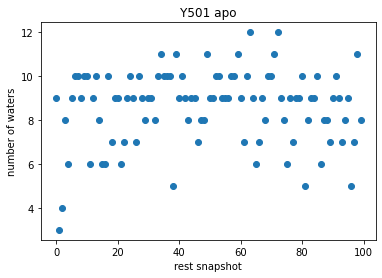

In [16]:
plt.scatter(range(len(neighbors)), [len(frame) for frame in neighbors])
plt.ylabel("number of waters")
plt.xlabel("rest snapshot")
plt.title("Y501 apo")

In [17]:
y501_waters = [len(frame) for frame in neighbors]
timeseries.statisticalInefficiency(y501_waters)

1.367887323943662

# Check last snapshot of reverse neq (1 ns) to see if waters match

In [24]:
def new_positions(hybrid_positions):
    n_atoms_new = htf._topology_proposal.n_atoms_new
    hybrid_indices = [htf._new_to_hybrid_map[idx] for idx in range(n_atoms_new)]
    return hybrid_positions[hybrid_indices, :]
    
def old_positions(hybrid_positions):
    n_atoms_old = htf._topology_proposal.n_atoms_old
    hybrid_indices = [htf._old_to_hybrid_map[idx] for idx in range(n_atoms_old)]
    return hybrid_positions[hybrid_indices, :]

def make_neq_traj(outdir, htf, i, phase, endstate, is_old=True, keep_solvent=True):
    name = 'old' if is_old else 'new'
    n_atoms = htf.old_positions(htf.hybrid_positions).shape[0] if is_old else htf.new_positions(htf.hybrid_positions).shape[0]
    
#     snapshots = np.zeros((100, n_atoms, 3))
    snapshots = []
    for j in range(100):
        if os.path.isfile(os.path.join(outdir, f"{i}_{phase}_{j}_forward_neq_{name}_waters.npy")):
            with open(os.path.join(outdir, f"{i}_{phase}_{j}_forward_neq_{name}_waters.npy"), "rb") as f:
                snapshot = np.load(f)
#                 snapshots[j] = snapshot[-1]
                snapshots.append(snapshot[-1])
    snapshots = np.array(snapshots)
    print(f"loaded {snapshots.shape[0]} snapshots")
    print(snapshots.shape)
            
    lengths = np.array([val[i].value_in_unit_system(unit.md_unit_system) for i, val in enumerate(htf.hybrid_system.getDefaultPeriodicBoxVectors())])
    lengths = np.array([lengths], dtype=np.float64)
    lengths = np.repeat(lengths, snapshots.shape[0], axis=0)

    angles = np.array([90, 90, 90])
    angles = np.repeat(np.array([angles]), snapshots.shape[0], axis=0)
        
    if is_old:
        traj = md.Trajectory(snapshots, md.Topology.from_openmm(htf._topology_proposal.old_topology), unitcell_lengths=lengths, unitcell_angles=angles)
    else:
        traj = md.Trajectory(snapshots, md.Topology.from_openmm(htf._topology_proposal.new_topology), unitcell_lengths=lengths, unitcell_angles=angles)
        
#     box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])
#     vectors = np.array([box_vectors]) 
           
#     # Set unit cell vectors in traj 
#     traj.unitcell_vectors = np.repeat(vectors, snapshots.shape[0], axis=0)
    traj.image_molecules(inplace=True)
    
    if not keep_solvent:
        traj = traj.remove_solvent(exclude=['Na+', 'Cl-'])
    
    return traj
       

## Y501 complex (15/145)

In [17]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/15/145/"
i = 145
phase = 'complex'
endstate = 1
is_old = False
htf = pickle.load(open(os.path.join(outdir, f"{i}_{phase}.pickle"), "rb"))

In [20]:
traj = make_neq_traj(outdir, htf, i, phase, endstate, is_old=is_old)

loaded 100 snapshots
(100, 185792, 3)


In [21]:
traj.save(os.path.join(outdir, f"{i}_{phase}_Y501_neq.dcd"))
traj[0].save(os.path.join(outdir, f"{i}_{phase}_Y501_neq.pdb"))

In [43]:
tyr_atoms = []
for atom in traj.topology.atoms:
    if atom.residue.resSeq == 501 and atom.residue.name == 'TYR':
        if atom.name == 'OH':
            print(atom, atom.residue.resSeq, atom.index)
            tyr_atoms.append(atom.index)

TYR501-OH 501 2620


In [44]:
water_atoms = traj.topology.select("water and symbol == 'O'")

In [45]:
neighbors = md.compute_neighbors(traj, 0.5, tyr_atoms, haystack_indices=water_atoms)

Text(0.5, 1.0, 'Y501 complex')

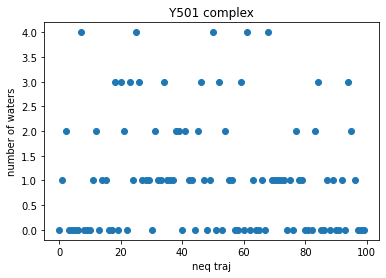

In [46]:
plt.scatter(range(len(neighbors)), [len(frame) for frame in neighbors])
plt.ylabel("number of waters")
plt.xlabel("neq traj")
plt.title("Y501 complex")

In [47]:
y501_waters = [len(frame) for frame in neighbors]
timeseries.statisticalInefficiency(y501_waters)


1.0

## Y501 apo (15/145)

In [22]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/15/145/"
i = 145
phase = 'apo'
endstate = 1
is_old = False
htf = pickle.load(open(os.path.join(outdir, f"{i}_{phase}.pickle"), "rb"))

In [25]:
traj = make_neq_traj(outdir, htf, i, phase, endstate, is_old=is_old)

loaded 99 snapshots
(99, 49205, 3)


In [26]:
traj.save(os.path.join(outdir, f"{i}_{phase}_Y501_neq.dcd"))
traj[0].save(os.path.join(outdir, f"{i}_{phase}_Y501_neq.pdb"))

In [50]:
tyr_atoms = []
for atom in traj.topology.atoms:
    if atom.residue.resSeq == 501 and atom.residue.name == 'TYR':
        if atom.name == 'OH':
            print(atom, atom.residue.resSeq, atom.index)
            tyr_atoms.append(atom.index)

TYR501-OH 501 2620


In [51]:
water_atoms = traj.topology.select("water and symbol == 'O'")

In [52]:
neighbors = md.compute_neighbors(traj, 0.5, tyr_atoms, haystack_indices=water_atoms)

Text(0.5, 1.0, 'Y501 apo')

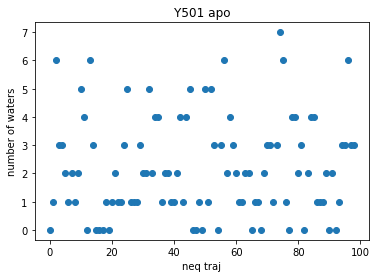

In [53]:
plt.scatter(range(len(neighbors)), [len(frame) for frame in neighbors])
plt.ylabel("number of waters")
plt.xlabel("neq traj")
plt.title("Y501 apo")

In [54]:
y501_waters = [len(frame) for frame in neighbors]
timeseries.statisticalInefficiency(y501_waters)


1.2224422079231516

## Y501 complex (15/146)

In [18]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/15/146/"
i = 146
phase = 'complex'
endstate = 1
is_old = False
htf = pickle.load(open(os.path.join(outdir, f"{i}_{phase}.pickle"), "rb"))

In [22]:
traj = make_neq_traj(outdir, htf, i, phase, endstate, is_old=is_old)

loaded 100 snapshots
(100, 183585, 3)


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


In [23]:
traj.save(os.path.join(outdir, f"{i}_{phase}_Y501_neq.dcd"))
traj[0].save(os.path.join(outdir, f"{i}_{phase}_Y501_neq.pdb"))

In [24]:
tyr_atoms = []
for atom in traj.topology.atoms:
    if atom.residue.resSeq == 501 and atom.residue.name == 'TYR':
        if atom.name == 'OH':
            print(atom, atom.residue.resSeq, atom.index)
            tyr_atoms.append(atom.index)

TYR501-OH 501 2618


In [25]:
water_atoms = traj.topology.select("water and symbol == 'O'")

In [26]:
neighbors = md.compute_neighbors(traj, 0.5, tyr_atoms, haystack_indices=water_atoms)

<ipython-input-26-6682592506a7>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  neighbors = md.compute_neighbors(traj, 0.5, tyr_atoms, haystack_indices=water_atoms)


Text(0.5, 1.0, 'Y501 complex')

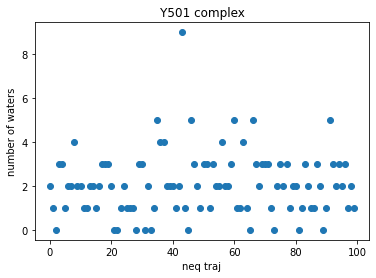

In [27]:
plt.scatter(range(len(neighbors)), [len(frame) for frame in neighbors])
plt.ylabel("number of waters")
plt.xlabel("neq traj")
plt.title("Y501 complex")

In [28]:
y501_waters = [len(frame) for frame in neighbors]
timeseries.statisticalInefficiency(y501_waters)


1.0

In [29]:
htf._atom_classes['core_atoms']

{2591,
 2592,
 2593,
 2594,
 2595,
 2596,
 2597,
 2598,
 2599,
 2600,
 2601,
 2602,
 2603,
 2604,
 2605,
 2606,
 2607,
 2608,
 2609,
 2610,
 2611,
 2617,
 2618,
 2619,
 2620,
 2621,
 2622,
 2623,
 2624,
 2625}

In [36]:
for atom in htf.hybrid_topology.atoms:
    if atom.residue.resSeq == 501 and atom.residue.name == 'ASN':
        print(atom.index, atom)

2605 ASN501-N
2606 ASN501-H
2607 ASN501-CA
2608 ASN501-HA
2609 ASN501-CB
2610 ASN501-HB2
2611 ASN501-HB3
2612 ASN501-CG
2613 ASN501-OD1
2614 ASN501-ND2
2615 ASN501-HD21
2616 ASN501-HD22
2617 ASN501-C
2618 ASN501-O
183578 ASN501-CG
183579 ASN501-CD1
183580 ASN501-HD1
183581 ASN501-CE1
183582 ASN501-HE1
183583 ASN501-CZ
183584 ASN501-OH
183585 ASN501-HH
183586 ASN501-CE2
183587 ASN501-HE2
183588 ASN501-CD2
183589 ASN501-HD2


## Y501 apo (15/146)

In [37]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/15/146/"
i = 146
phase = 'apo'
endstate = 1
is_old = False
htf = pickle.load(open(os.path.join(outdir, f"{i}_{phase}.pickle"), "rb"))

In [38]:
traj = make_neq_traj(outdir, htf, i, phase, endstate, is_old=is_old)

loaded 100 snapshots
(100, 44750, 3)


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2003, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


In [39]:
tyr_atoms = []
for atom in traj.topology.atoms:
    if atom.residue.resSeq == 501 and atom.residue.name == 'TYR':
        if atom.name == 'OH':
            print(atom, atom.residue.resSeq, atom.index)
            tyr_atoms.append(atom.index)

TYR501-OH 501 2618


In [40]:
water_atoms = traj.topology.select("water and symbol == 'O'")

In [41]:
neighbors = md.compute_neighbors(traj, 0.5, tyr_atoms, haystack_indices=water_atoms)

<ipython-input-41-6682592506a7>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  neighbors = md.compute_neighbors(traj, 0.5, tyr_atoms, haystack_indices=water_atoms)


Text(0.5, 1.0, 'Y501 apo')

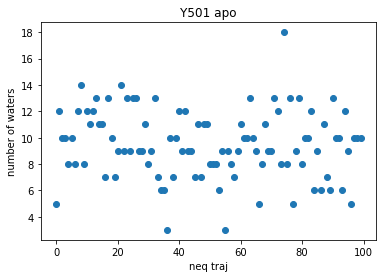

In [42]:
plt.scatter(range(len(neighbors)), [len(frame) for frame in neighbors])
plt.ylabel("number of waters")
plt.xlabel("neq traj")
plt.title("Y501 apo")

In [43]:
y501_waters = [len(frame) for frame in neighbors]
timeseries.statisticalInefficiency(y501_waters)


1.583262190983273